# Часть 1. Проверка гипотезы в Python и составление аналитической записки

# Проверка гипотезы для "Яндекс.Книги"

- Автор: Авиленко Арина
- Дата: 22.05.2025

## Цели и задачи проекта


Статистически доказать или опровергнуть гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении `Яндекс.Книги`, чем пользователи из Москвы.

## Описание данных


Данные содержат информацию о времени активности пользователей приложения в часах, разделённую по городам: Санкт-Петербург и Москва. Каждый пользователь имеет уникальный идентификатор. 

## Содержимое проекта

- Предварительный анализ данных: проверка на дубликаты идентификаторов пользователей.
- Сравнение размеров групп пользователей из Санкт-Петербурга и Москвы.
- Выбор и обоснование типа t-теста для проверки гипотезы.
- Проведение t-теста и определение p-value.
- Интерпретация результатов теста и формулировка выводов.
- Возможные объяснения полученных результатов.
- Подготовка аналитической записки с описанием проведённого анализа, результатов и выводов.

---

## 1. Загрузка данных и знакомство с ними


In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime, timedelta

In [2]:
# Импортируем данные 
yandex_books = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
yandex_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
yandex_books.tail()

,Unnamed: 0,city,puid,hours
8779,8779,Санкт-Петербург,1130000028554332,4.107774
8780,8780,Санкт-Петербург,1130000030307246,45.069222
8781,8781,Санкт-Петербург,1130000038726322,0.211944
8782,8782,Санкт-Петербург,1130000047892100,4.311841
8783,8783,Санкт-Петербург,1130000061443598,20.847222


Исходный датасет `yandex_books` содержит 4 стобца:
- "Unnamed: 0" дублирует индекс, его можно убрать
- "city" содержит информацию о городе
- "puid" уникальный идентификатор пользователя
- "hours" время прослушивания

Типы столбцов были определены корректно, вносить изменения не требуется.

In [5]:
# Оставляем в датасете столбцы с необходимой информацией
yandex_books = yandex_books[['city','puid','hours']]

In [6]:
# Проверим число уникальных идентификаторов пользователей

n_uniq_puid = yandex_books['puid'].nunique()
dubs_u = yandex_books.shape[0]-yandex_books['puid'].nunique()
dubs_perc = round(100-yandex_books['puid'].nunique()/yandex_books.shape[0]*100,0)

print(f'Уникальных пользователей {n_uniq_puid}')
print(f'Дубликатов {dubs_u} штук или {dubs_perc}%')

Уникальных пользователей 8540
Дубликатов 244 штук или 3.0%


In [7]:
yandex_books['puid'].duplicated().sum()

244

Всего в датасете есть 8540 уникальных пользователей, а строк 8784. Попробуем понять, откуда появились 244 дубликата, и придумать, что с ними делать.

In [8]:
print(yandex_books.duplicated().sum(), 
      yandex_books[['puid', 'hours']].duplicated().sum(),
      yandex_books[['puid', 'city']].duplicated().sum())

0 0 0


Дубликаты в самой таблице, а также в комбинациях Пользователь-Город и Пользователь-Время отсутствуют. Значит, задублированы именно значения идентификатора пользователя.

In [9]:
yandex_books.groupby('puid')['city'].nunique().sort_values(ascending=False)

puid
1977784899          2
227462418           2
1450333124          2
430410194           2
9979490             2
                   ..
521764791           1
521705370           1
521658742           1
519303101           1
1130000065762132    1
Name: city, Length: 8540, dtype: int64

In [10]:
# Выведем один из примеров с дублированным id
yandex_books.loc[yandex_books['puid'] == yandex_books.groupby('puid')['hours'].nunique().idxmax()]

,city,puid,hours
35,Москва,2637041,10.317371
6247,Санкт-Петербург,2637041,3.883926


На примере видно, что один и тот же пользователь мог слушать книги в приложении в обоих тестируемых городах.
Это неудивительно - и москвичи, и петербуржцы часто перемещаются между столицами по разным причинам, будь то работа или туризм. Книгу можно слушать и в отпуске, и после тяжелого трудового дня.

В данном случае нам необходимо подтвердить или опровергуть гипотезу о  том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Поэтому такие путешественники нарушат условие о `независимости` выборок, так что их следует удалить. Важно учесть, что таких дубликатов 3 * 2 = 6%.

In [11]:
# Выделим в отдельный список id дубликатов
doubled = yandex_books.groupby('puid')['city'].nunique().reset_index()
doubled = doubled['puid'].loc[doubled['city'] > 1]

In [12]:
# Сначала находим индексы строк для удаления
indices_to_drop = yandex_books[yandex_books['puid'].isin(doubled)].index
print(indices_to_drop)

Int64Index([  35,  134,  145,  150,  187,  230,  266,  281,  315,  335,
            ...
            8681, 8723, 8761, 8767, 8769, 8771, 8772, 8773, 8775, 8779],
           dtype='int64', length=488)


In [13]:
# Затем удаляем их
yandex_books = yandex_books.drop(indices_to_drop)

In [14]:
# Выводим обновленную информацию о датасете
yandex_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8296 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8296 non-null   object 
 1   puid    8296 non-null   int64  
 2   hours   8296 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 259.2+ KB


Итак, дубликаты удалены. Можем приступать к более глубокой оценке данных и проведению теста.

Изучим статистики столбца 'hours' как в целом, так и по группам, которые собираемся тестировать далее.

In [15]:
yandex_books['hours'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    8296.000000
mean       10.963892
std        37.753906
min         0.000022
25%         0.057493
50%         0.884214
75%         5.944675
95%        55.625093
99%       153.656226
max       978.764775
Name: hours, dtype: float64

In [16]:
yandex_books.groupby('city')['hours'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

city,Москва,Санкт-Петербург
count,5990.000000,2306.000000
mean,10.848192,11.264433
std,36.925622,39.831755
min,0.000022,0.000025
25%,0.057042,0.060173
50%,0.888232,0.875355
75%,5.933439,6.138424
95%,54.929483,56.545642
99%,154.688119,146.847159
max,857.209373,978.764775


Как можно увидеть по выведенным значениям
1. Распределение значений столбца 'hours' имеет тяжелый правый хвост как на тотале, так и по группам
2. Для обеих групп наблюдаются очевидные выбросы выше 99-го перцентиля *(MAX 857 для Москвы и 979 для Питера при 75-ом перцентиле около 6-ти)*, что влияет на распределение среднего и может помешать применению, например t-теста Стьюдента.

Такие выбросы стоит удалить.

In [17]:
# Удаляем выбросы выше 99-го перцентиля
yandex_books = yandex_books.loc[yandex_books['hours'] <= yandex_books['hours'].quantile(0.99)]

In [18]:
# Выводим статистики для очищенных данных
yandex_books.groupby('city')['hours'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

city,Москва,Санкт-Петербург
count,5929.000000,2284.000000
mean,8.064964,8.377901
std,19.733973,19.723539
min,0.000022,0.000025
25%,0.055492,0.057032
50%,0.856322,0.852310
75%,5.639621,5.672186
95%,45.257274,46.474395
99%,111.690496,104.748780
max,153.639891,152.338086


Данные были очищены, а статистики соответственно поменялись.

- Число наблюдений в Москве составляет **5929**, а в Санкт-Петербурге **2284**. Разница выборок большая, но, учитывая, что обе выборки значительно превосходят положенные ЦПТ 30 наблюдений, уравнивать группы в данном случае не будем.
- Стандартное отклонение для обеих групп выровнялось и составляет на данный момент **19,7** против 36,9 для Москвы и 39,8 для Петербурга ранее. Можно говорить о равенстве дисперсий (квардрат std)

Посмотрим на визуальное распределение значений столбца прослушиваний 'hours' для Москвы и Санкт-Петербурга.

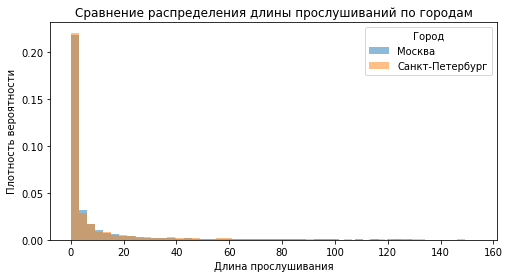

In [19]:
plt.figure(figsize=(8, 4))

for i in yandex_books['city'].unique():
    yandex_books.loc[yandex_books['city'] == i, 'hours'].plot(
        kind='hist',
        density=True,
        bins=50,
        alpha=0.5,
        label=f'{i}',
        legend=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределения длины прослушиваний по городам')
plt.xlabel('Длина прослушивания')
plt.ylabel('Плотность вероятности')
plt.legend(title='Город')
plt.show()

Как видно по построенному графику с распределением числа уникальных сессий по дням, динамики для тестовой и контрольной группы имеют очень схожий рисунок. Распределение действительно сильно скошено вправо, но очевидные выбросы были ранее удалены.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Подводя итог предобработке данных, можно сказать, что мы собрали достаточно оснований для проверки гипотезы проекта с помощью наиболее распространенного `t-теста Стьюдента`, который позволяет оценить степень различия средних двух выборок.

- Независимость выборок:  
Были удалены пользователи, у которых были прослушивания в обоих городах. Выборки независимы
- Нормальность распределения среднего:
Удалены выбросы, которые могли повлиять на распределение среднего. И согласно ЦПТ при достаточно большом объёме выборки ***среднее значение этой выборки будет распределяться нормально***. Нормальность же распределения самой величины не является условием применения t-теста
- Гомогенность дисперсий:
После проведенных преобразований стандартное отклонение, а, значит, и дисперсия для обеих выборок, равны
- Размер выборок: 
Выборки имеют достаточно наблюдений

In [20]:
# Проверка гипотезы с помощью классического теста Стьюдента
metric_a = yandex_books['hours'].loc[yandex_books['city'] == 'Санкт-Петербург'] ## выборка целевой метрики для группы A
metric_b = yandex_books['hours'].loc[yandex_books['city'] == 'Москва']## выборка целевой метрики для группы B

alpha = 0.05

stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='greater' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки(metric_a) больше второй выборки
)

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента = {round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')

p-value теста Стьюдента = 0.26
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


## 3. Аналитическая записка


Эксперимент проводился с `1 сентября` по `11 декабря 2024 года` с участием `2 284` пользователей в группе "a" **Санкт-Петербург** и `5 929` пользователей в тестовой группе "b" **Москва**.

В ходе предварительного анализа метрик приложения было выявлено статистически значимое различие в LTV между пользователями из Санкт-Петербурга и Москвы. Данный факт требовал дополнительного исследования для подтверждения гипотезы о различии в поведении пользователей двух крупнейших городов России.

Поскольку значение `p-value` (`0.26`) значительно превышает заданный уровень значимости (`0.05`), мы не можем отвергнуть нулевую гипотезу. Это означает, что статистически значимых различий в среднем времени взаимодействия с контентом приложения между пользователями из Санкт-Петербурга и Москвы не обнаружено.

**Возможные причины отсутствия значимых различий**:
- Поведенческий фактор: на поведение пользователей могут влиять дополнительные факторы (возраст, доход, образование), которые не были учтены в анализе
- Временной фактор: различия в поведении могли быть временными и не проявились в рассматриваемом периоде
- Особенности продукта: приложение может быть одинаково привлекательным для обеих аудиторий, что нивелирует региональные различия

----

# Часть 2. Анализ результатов A/B-тестирования

## 1. Цели исследования

- Подготовить данные для проведения теста

- Сравнить конверсию в покупку между группами

- Определить, стоит ли запускать новую версию сайта

## 2. Загрузка данных, оценка их целостности


In [21]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

## 3. Оценка корректности проведения теста

In [22]:
# Выводим первые строки таблицы participants
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [23]:
participants['ab_test'].unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

Сиходная таблица с участниками тестов содержит информацию о 2-х проходивших тестах. Нужный нам тест имеет название 'interface_eu_test'. Проверим наличие дубликатов пользователей внутри нужного теста, а также внутри таблицы.

In [24]:
participants['user_id'].loc[participants['ab_test'] == 'interface_eu_test'].duplicated().sum()

0

In [25]:
participants['user_id'].duplicated().sum()

887

Как видно по выводам кода, 887 пользователей стали участниками обоих тестов. Так как по техническому заданию нам необходимо удалить таких участников (на их поведение мог повлиять параллельно проводящий тест), просто полностью удалим этих пользователей.

In [26]:
participants = participants.drop_duplicates(subset='user_id', keep = False)

In [27]:
# Фильтруем датасет, оставляя только нужных пользователей теста 'interface_eu_test'
participants = participants[['user_id','group','device']].loc[participants['ab_test'] == 'interface_eu_test']
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9963 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  9963 non-null   object
 1   group    9963 non-null   object
 2   device   9963 non-null   object
dtypes: object(3)
memory usage: 311.3+ KB


По итогу мы получили очищенную таблицу 'participants' с 3-мя колонками. Столбец содержит данные о 9963 участниках теста без дубликатов. Пропусков ни в одном из столбцов нет.

In [28]:
participants.groupby('group')['user_id'].count()

group
A    4952
B    5011
Name: user_id, dtype: int64

Пользователи распределены по группам достаточно равномерно.

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

Изучим данные таблицы 'events' с событиями.

In [29]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [30]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Таблица содержит 787 286 строк, дубликаты есть только в столбце 'details', который не пригодится нам в анализе. Проверим данные на дублирование.

In [31]:
events.duplicated().sum()

36318

В таблице есть 36 318 полных дубликатов строк, удалим их.

In [32]:
events = events.drop_duplicates()

Закончив с подготовкой данных, объединим таблицы с участниками и событиями по левому соединению, т.е. оставив события только участников A/B теста с интерфейсом.

In [33]:
ab_test_events = participants.merge(events,on='user_id',how='left')
ab_test_events.head()

,user_id,group,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,Mac,2020-12-08 22:15:35,login,NaN


In [34]:
ab_test_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68074 entries, 0 to 68073
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     68074 non-null  object        
 1   group       68074 non-null  object        
 2   device      68074 non-null  object        
 3   event_dt    68074 non-null  datetime64[ns]
 4   event_name  68074 non-null  object        
 5   details     18864 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 3.6+ MB


Итоговая таблица `ab_test_events` содержит 68 074 строк с пропусками только в столбце 'details'.

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [35]:
# Создадим отдельную таблицу с пользовательским id и датой регистрации
reg_date = ab_test_events[['user_id','event_dt']].loc[ab_test_events['event_name'] == 'registration']
reg_date = reg_date.rename(columns={'event_dt': 'reg_dt'})

In [36]:
# Создадим новую таблицу ab_test_events_filtered, присоединив данные о дате регистрации
ab_test_events_filtered = ab_test_events.merge(reg_date, on='user_id')
ab_test_events_filtered.head()

,user_id,group,device,event_dt,event_name,details,reg_dt
0,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31
1,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31
2,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31
3,0002CE61FF2C4011,B,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31
4,0002CE61FF2C4011,B,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31


In [37]:
# Создаем столбец 'days_since_reg' с промежутком времени события после регистрации
ab_test_events_filtered['days_since_reg'] = ab_test_events_filtered['event_dt']-ab_test_events_filtered['reg_dt']

In [38]:
# Задаем значение для сравнения (7 дней)
target_days = timedelta(days=7)

In [39]:
# Фильтруем таблицу по заданному промежутку события в 7 дней после регистрации
ab_test_events_filtered = ab_test_events_filtered.loc[ab_test_events_filtered['days_since_reg'] <= target_days]
ab_test_events_filtered.head()

,user_id,group,device,event_dt,event_name,details,reg_dt,days_since_reg
0,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0 days 00:00:00
1,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0 days 00:00:18
2,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0 days 00:00:26
3,0002CE61FF2C4011,B,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0 days 00:01:23
4,0002CE61FF2C4011,B,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1 days 17:38:04


In [40]:
ab_test_events_filtered['event_name'].unique()

array(['registration', 'login', 'product_page', 'product_cart',
       'purchase'], dtype=object)

Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

Используя калькулятор Эвана Миллера (https://www.evanmiller.org/ab-testing/sample-size.html), опеределим необходимый размер выборки для каждой из групп.

Вводимые показатели:
- базовый показатель конверсии — 30%
- Минимальный детектируемый эффект — 3% по ТЗ
- мощность теста — 80%
- достоверность теста — 95%

Итоговое значение выборки одной группы должно быть не меньше 3 692. Это условие выполняется — в пункте 3.1 было установлено, что размер выборок для группы A 4952 человек, для группы B 5011.


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [41]:
n_a = ab_test_events_filtered['user_id'].loc[ab_test_events_filtered['group']=='A'].nunique()
n_b = ab_test_events_filtered['user_id'].loc[ab_test_events_filtered['group']=='B'].nunique()
m_a = ab_test_events_filtered['user_id'].loc[(ab_test_events_filtered['group']=='A')&(ab_test_events_filtered['event_name']=='purchase')].nunique()
m_b = ab_test_events_filtered['user_id'].loc[(ab_test_events_filtered['group']=='B')&(ab_test_events_filtered['event_name']=='purchase')].nunique()

print(f'Для контрольной группы A общее число пользователей составляет {n_a}, число пользователей, совершивших покупку, {m_a}, конверсия равна {round(m_a/n_a*100,1)}%.')
print(f'Для тестовой группы B общее число пользователей составляет {n_b}, число пользователей, совершивших покупку, {m_b}, конверсия равна {round(m_b/n_b*100,1)}%.')

Для контрольной группы A общее число пользователей составляет 4952, число пользователей, совершивших покупку, 1377, конверсия равна 27.8%.
Для тестовой группы B общее число пользователей составляет 5011, число пользователей, совершивших покупку, 1480, конверсия равна 29.5%.


In [42]:
conv_change_abs = round((m_b/n_b - m_a/n_a)*100,1)
conv_change_perc = round((m_b/n_b)/(m_a/n_a)*100-100,1)

print(f'Конверсия в тестовой группе В выросла относительно конверсии контрольной группы А на {conv_change_abs} процентных пункта или на {conv_change_perc}%')

Конверсия в тестовой группе В выросла относительно конверсии контрольной группы А на 1.7 процентных пункта или на 6.2%


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

Предварительно, можно отметить, что конверсия в тестовой группе выше, чем в контрольной на 1,7 процентных пункта. То есть изменение есть и оно заметно. Попробуем оценить его значимость с помощью `Z-теста пропорций`, который позволяет определить, существует ли разницы в долях для независимых групп.

## 4. Оценка результатов A/B-тестирования

Сформулируем гипотезу:

$H_0$ - вероятности успеха (в данном случае совершения покупки пользователем в течение 7-ми дней после регистрации) для групп А и В равны или вероятность успеха для группы В меньше, чем для группы А  
$H_1$ - вероятность успеха для группы В больше, чем для группы А

In [43]:
alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.028262547212292124 < 0.05
Нулевая гипотеза не находит подтверждения!


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

**Результат теста:**

p-value = `0.028` (что меньше уровня значимости α = `0.05`).
Это означает, что разница в конверсиях между группами статистически значима на уровне 5%.

**Сравнение конверсий:**

Конверсия в группе A (контрольная): 27.8%

Конверсия в группе B (тестовая): 29.5%

Разница: 1.7 процентных пункта (29.5% - 27.8%).

**Проверка гипотезы:**

Гипотеза предполагала, что упрощение интерфейса увеличит конверсию как минимум на `3 процентных пункта`.

Фактическая разница (`1.7 п.п.`) меньше ожидаемого эффекта (`3 п.п.`).

**Заключение:**

Хотя разница статистически значима (p-value < 0.05), она не достигает заявленного минимального эффекта в 3 процентных пункта.
Упрощение интерфейса не привело к росту конверсии на ожидаемые +3%.

**Рекомендации:**
- Можно считать, что изменение интерфейса оказало положительное влияние (разница есть, но меньше ожидаемой).
- Стоит проанализировать, почему эффект оказался ниже прогнозируемого (возможно, нужны дополнительные доработки или тестирование других изменений).
- Если бизнес-целью было именно +3%, то текущий результат недостаточен для принятия решения о внедрении.